In [ ]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
import tensorflow as tf

import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

import missingno as msno

from xgboost import XGBClassifier

# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/train.csv')
df_val = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Data Science/Analysis/TPS Sep 2021/test.csv')

In [ ]:
# sampling df bc its too big
sample_df = df.sample(int(len(df) * 0.15))

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

df_red = reduce_mem_usage(sample_df)

Memory usage after optimization is: 262.19 MB
Decreased by 70.1%


In [ ]:
y = df_red.claim
x = df_red.drop('claim', axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

# Data Distribution

## Target

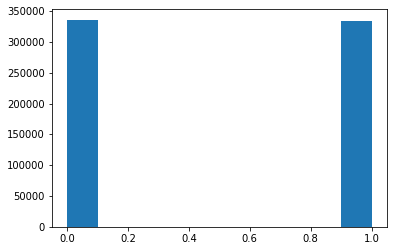

In [ ]:
plt.hist(y_train)
plt.show()

Pretty well balanced

## Features

In [ ]:
x_train.describe()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118
count,670543.000000,659861.000000,659898.000000,659800.000000,659694.000000,659768.000000,659648.000000,659757.000000,6.597580e+05,6.598940e+05,659901.000000,659760.000000,6.595880e+05,659745.000000,659895.000000,659781.000000,659739.000000,659699.000000,659815.000000,659853.000000,659599.000000,659743.000000,659845.000000,659744.000000,659563.000000,659685.000000,6.597330e+05,6.596350e+05,6.599720e+05,659746.000000,659777.000000,659579.000000,6.597140e+05,6.597560e+05,659892.000000,6.598260e+05,659617.000000,659821.000000,659691.000000,659778.000000,...,659716.000000,659833.000000,659843.000000,6.596810e+05,659658.000000,6.597790e+05,659753.000000,6.596470e+05,659851.000000,659579.000000,659748.000000,659594.000000,659715.000000,659758.000000,659740.000000,659826.000000,659794.000000,659911.000000,659948.000000,6.598590e+05,659736.000000,659741.000000,659757.000000,6.599960e+05,659722.000000,659958.000000,659784.000000,659586.000000,659771.000000,6.598340e+05,659585.000000,659749.000000,659794.000000,659712.000000,659789.000000,659820.000000,659589.000000,6.597180e+05,659729.000000,659920.000000
mean,478933.194401,0.090221,0.345890,4070.631011,0.201169,0.304911,-0.069795,1620.001060,3.772790e+05,1.803298e+15,5325.755229,0.730302,1.843274e+09,0.247656,7.000264,0.019244,444.978148,6.891672,4.496615,22.472344,203.646362,61132.169266,2.269658,87.166967,0.341529,414.951814,3.378953e+12,1.251896e+12,2.257734e+06,0.329112,7.881479,0.394105,1.346237e+05,3.576488e+05,-0.000004,2.781057e+16,185.805257,406.135572,1.768091,1982.652127,...,1.548596,0.194164,3.240454,1.054750e+11,152.974862,6.133376e+06,635.003813,3.251470e+10,26.638962,207.331238,3807.667661,6.733919,0.366784,4870.128175,132.244211,0.820392,13.117950,3845.319490,0.999970,1.415091e+13,1.682455,0.426200,20.194269,3.212204e+05,548.729321,3865.441536,0.178095,0.160781,0.014197,1.671243e+09,0.398618,-19.906640,2.074067,23.907714,1.757445,63205.486684,1.208811,4.275393e+16,3963.129298,0.559030
std,276551.681616,0.043614,0.146371,6417.546921,0.212306,0.145318,2.123148,1276.050415,3.457063e+05,2.332596e+15,10076.173887,1.495930,2.124909e+09,0.101199,6.620248,0.101723,631.406752,1.714848,3.903435,14.619876,281.081848,89885.359372,0.897393,37.367697,1.643138,314.716210,5.654826e+12,1.642027e+12,2.304170e+06,0.433951,5.937837,0.781553,2.036903e+05,4.623822e+05,0.001533,3.452656e+16,701.996748,314.825972,0.588368,1959.487806,...,9.078279,0.162443,1.992506,9.906334e+10,227.998171,8.776611e+06,583.325394,3.069270e+10,25.488639,158.228718,3535.964385,3.158122,0.146427,8430.461046,110.058708,0.713047,12.738409,6427.625328,0.001535,1.640511e+13,0.711390,0.283661,19.602325,3.275653e+05,864.125714,6681.627560,0.123340,0.141585,0.016258,1.875573e+09,0.298073,18.568044,0.895285,45.626317,10.088244,92502.221802,0.114940,6.731387e+16,3158.291221,0.408355
min,1.000000,-0.149910,-0.019044,-9421.700000,-0.082122,-0.006990,-12.791000,-224.800000,-2.833700e+04,-1.111800e+15,-26404.000000,-8.086300,-4.081000e+08,-0.103800,-0.835840,-0.334600,-116.880000,-3.402500,-0.066527,-4.422500,-58.834000,-84079.000000,-6.009400,-20.514000,-5.651500,-71.502000,-6.771900e+11,-9.384200e+11,-4.706000e+05,-0.005659,-0.529990,-3.800900,-3.370900e+05,-6.055900e+05,-0.003881,-2.068900e+16,-2376.000000,-39.938000,0.546100,-433.700000,...,-24.270000,-0.017615,0.964200,-7.345700e+10,-28.671000,-2.992000e+06,-72.338000,-5.949500e+09,-7.616400,-22.474000,-292.070000,-0.257570,-0.012158,-12829.000000,-12.922000,-3.227200,-1.352400,-7764.300000,0.996110,-5.714600e+12,0.608200,-0.034559,-4.294900,-2.277700e+05,-222.210000,-11581.000000,-0.029027,-0.066726,-0.007535,-5.390500e+08,-0.042355,-105.86000

NameError: ignored

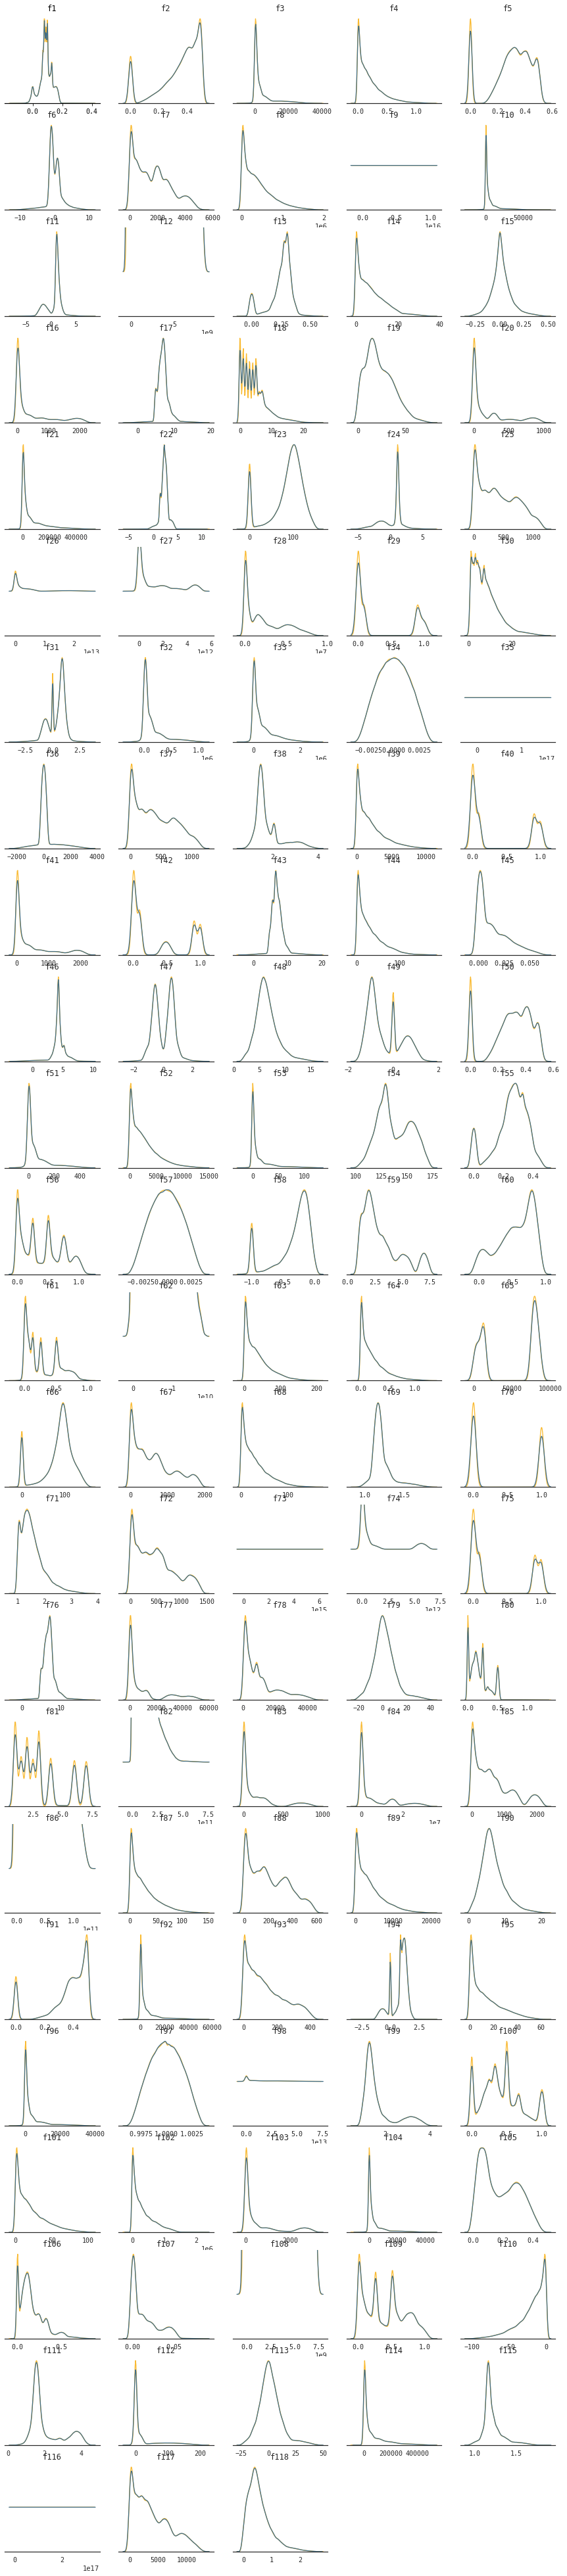

In [ ]:
train = pd.concat([x_train, y_train], axis=1,)
test = pd.concat([x_test, y_test], axis=1,)

pfig = plt.figure(figsize = (15, 71))
cols = train.columns.tolist()[1:119]
for i in cols:
    plt.subplot(24,5,cols.index(i)+1)
    sns.set_style("white")
    plt.title(i, size = 12, fontname = 'monospace')
    a = sns.kdeplot(train[i], color = '#f9ba32', linewidth = 1.3)
    sns.kdeplot(test[i], color = '#426e86', linewidth = 1.3)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname = 'monospace')
    plt.yticks([])
    for j in ['right', 'left', 'top']:
        a.spines[j].set_visible(False)
        a.spines['bottom'].set_linewidth(1.2)
        
fig.tight_layout(h_pad = 3)

plt.figtext(0.335, 1.02, 'Distribution of features', color = '#2f3131', fontname = 'monospace', size = 25)
plt.figtext(0.3, 1.01, 'train', color = '#f9ba32', fontname = 'monospace', size = 18)
plt.figtext(0.66, 1.01, 'test', color = '#426e86', fontname = 'monospace', size = 18)

plt.show()

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Missing Data

In [ ]:
def faltantes_percentual(df):
  """we can see how much (%) of each column is missing """
  print((df.isnull().sum() / len(df.iloc[:,0])*100).sort_values(ascending=False))

In [ ]:
faltantes_percentual(x_train)
print(faltantes_percentual(x_train).count())

In [ ]:
#plot bars with white stripes for missing values
msno.matrix(x_train)

The missing data appear at sight to be MAR (Missing At Random, when the missingness is not random, but where missingness can be fully accounted for by variables where there is complete information).

In [ ]:
# set plot resolution and size
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(2, 15), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 2)
gs.update(wspace=1.5, hspace=0.05)

background_color = "#f6f5f5"
sns.set_palette(['#ffd514']*120)

ax0 = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax0.spines[s].set_visible(False)
ax0.set_facecolor(background_color)
ax0_sns = sns.barplot(ax=ax0, y=missing_train_df['feature'], x=missing_train_df['count'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax0_sns.set_xlabel("missing values",fontsize=3, weight='bold')
ax0_sns.set_ylabel("features",fontsize=3, weight='bold')
ax0_sns.tick_params(labelsize=3, width=0.5, length=1.5)
ax0_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax0.text(0, -1.8, 'Train Dataset', fontsize=4, ha='left', va='top', weight='bold')
ax0.text(0, -1.105, 'Number of missing value are around 15,000 or 1.6%', fontsize=2.5, ha='left', va='top')
ax0.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# data label
for p in ax0.patches:
    value = f'{p.get_width():,.0f} | {(p.get_width()/df.shape[0]):,.1%}'
    x = p.get_x() + p.get_width() + 1000
    y = p.get_y() + p.get_height() / 2 
    ax0.text(x, y, value, ha='left', va='center', fontsize=2, 
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.2))
    
background_color = "#f6f5f5"
sns.set_palette(['#ff355d']*120)
    
ax3 = fig.add_subplot(gs[0, 1])
for s in ["right", "top"]:
    ax3.spines[s].set_visible(False)
ax3.set_facecolor(background_color)
ax3_sns = sns.barplot(ax=ax3, y=missing_test_df['feature'], x=missing_test_df['count'], 
                      zorder=2, linewidth=0, orient='h', saturation=1, alpha=1)
ax3_sns.set_xlabel("missing values",fontsize=3, weight='bold')
ax3_sns.set_ylabel("features",fontsize=3, weight='bold')
ax3_sns.tick_params(labelsize=3, width=0.5, length=1.5)
ax3_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax3_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax3.text(0, -1.8, 'Test Dataset', fontsize=4, ha='left', va='top', weight='bold')
ax3.text(0, -1.105, 'Number of missing value are around 7,000 - 8,000 or 1.6%', fontsize=2.5, ha='left', va='top')
ax3.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# data label
for p in ax3.patches:
    value = f'{p.get_width():,.0f} | {(p.get_width()/df_val.shape[0]):,.1%}'
    x = p.get_x() + p.get_width() + 500
    y = p.get_y() + p.get_height() / 2 
    ax3.text(x, y, value, ha='left', va='center', fontsize=2, 
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.2))


# Preprocessing

In [ ]:
x_train_inputed = SimpleImputer(np.nan, strategy='mean').fit_transform(x_train)
x_test_inputed = SimpleImputer(np.nan, strategy='mean').fit_transform(x_test)

In [ ]:
x_train_qt = QuantileTransformer().fit_transform(x_train_inputed)
x_test_qt = QuantileTransformer().fit_transform(x_test_inputed)

In [ ]:
x_train_pt = PowerTransformer().fit_transform(x_train_inputed)
x_test_pt =  PowerTransformer().fit_transform(x_test_inputed)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [ ]:
x_train_sc = StandardScaler().fit_transform(x_train_inputed)
x_test_sc = StandardScaler().fit_transform(x_test_inputed)

In [ ]:
PCA(n_components=70)

x_train_PCA = PCA(n_components=70).fit_transform(x_train_pt)
x_test_PCA = PCA(n_components=70).fit_transform(x_test_pt)

# Baseline

In [ ]:
from sklearn.metrics import make_scorer
lr_model = LogisticRegression()
#lr_model.fit(x_train, y_train)
cv_base = cross_val_score(lr_model,x_test_PCA, y_test, cv=5)

In [ ]:
cv_base1 = cross_val_predict(lr_model,x_test_PCA, y_test, cv=5)

In [ ]:
roc_auc_score(y_test, cv_base1)

0.5257302864945376

# Model Selection

## RandomForest

Takes too damn long to run

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
#rf_model.fit(x_train, y_train)
#pred2 = rf_model.predict(x_test_pp)

cv_rf = cross_val_score(rf_model,x_train_PCA, y_train, cv=5)
cv_rf.mean()

In [ ]:
rf_model.fit(x_train_inputed,y_train)
pred_rf = model.predict(x_test_inputed)
roc_auc_score(y_test,pred_rf)

## XGBoost

In [ ]:
xgb = XGBClassifier(paramsXGB = {'max_depth': 3, 
             'learning_rate': 0.005702659398906191, 
             'n_estimators': 22404, 
             'min_child_weight': 25, 
             'gamma': 0.00010151247994797229, 
             'alpha': 7.148020356730985, 
             'lambda': 0.1378423649746119, 
             'colsample_bytree': 0.7969227570988136, 
             'subsample': 0.6382893449313995,
             'tree_method': 'gpu_hist',
             'booster': 'gbtree',
             'random_state': 42,
             'use_label_encoder': False,
             'eval_metric': 'auc'})
#cv_xgb = cross_val_score(xgb ,x_test_inputed, y_test, cv=5)

In [ ]:
xgb.fit(x_train_inputed,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic',
              paramsXGB={'alpha': 7.148020356730985, 'booster': 'gbtree',
                         'colsample_bytree': 0.7969227570988136,
                         'eval_metric': 'auc', 'gamma': 0.00010151247994797229,
                         'lambda': 0.1378423649746119,
                         'learning_rate': 0.005702659398906191, 'max_depth': 3,
                         'min_child_weight': 25, 'n_estimators': 22404,
                         'random_state': 42, 'subsample': 0.6382893449313995,
                         'tree_method': 'gpu_hist',
                         'use_label_encoder': False},
              random_state=0, reg_alpha=0, reg_lambda=1, scal

In [ ]:
pred_xgb = xgb.predict(x_test_inputed)

In [ ]:
roc_auc_score(y_test, pred_xgb)

0.5592023167197695

## LighGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)
lgbm.fit(x_train_inputed,y_train)
pred_lgbm = lgbm.predict(x_test_inputed)
roc_auc_score(y_test, pred_lgbm)

# Neural Network

In [ ]:
model = Sequential()
model.add(Dense(30, input_dim=119, kernel_initializer='normal', activation='sigmoid'))
#model.add(Dropout(0.2))
model.add(Dense(30, kernel_initializer='normal', activation='sigmoid'))
#model.add(Dropout(0.2))
#model.add(Dense(30, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(30, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer='normal', activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

In [ ]:
model.fit(x_train_qt, y_train, batch_size=556, epochs = 20, validation_data=(x_test_qt, y_test))

Epoch 1/20
1207/1207 [==============================] - 11s 6ms/step - loss: 0.6912 - auc: 0.5000 - val_loss: 0.6885 - val_auc: 0.5000
Epoch 2/20
1207/1207 [==============================] - 7s 6ms/step - loss: 0.6888 - auc: 0.5000 - val_loss: 0.6889 - val_auc: 0.5000
Epoch 3/20
1207/1207 [==============================] - 8s 6ms/step - loss: 0.6886 - auc: 0.5000 - val_loss: 0.6891 - val_auc: 0.5000
Epoch 4/20
1207/1207 [==============================] - 7s 6ms/step - loss: 0.6885 - auc: 0.5000 - val_loss: 0.6888 - val_auc: 0.5000
Epoch 5/20
1207/1207 [==============================] - 8s 7ms/step - loss: 0.6886 - auc: 0.5000 - val_loss: 0.6885 - val_auc: 0.5000
Epoch 6/20
1207/1207 [==============================] - 7s 6ms/step - loss: 0.6885 - auc: 0.5000 - val_loss: 0.6892 - val_auc: 0.5000
Epoch 7/20
1207/1207 [==============================] - 7s 6ms/step - loss: 0.6885 - auc: 0.5000 - val_loss: 0.6882 - val_auc: 0.5000
Epoch 8/20
1207/1207 [==============================] - 8s 6m

In [ ]:
pred_nn = model.predict(x_test_qt)

In [ ]:
roc_auc_score(y_test, pred_nn)

0.5

In [ ]:
pred_nn.shape

(287376, 1)

In [ ]:
missing_train_df = pd.DataFrame(df.isna().sum())
missing_train_df = missing_train_df.drop(['id', 'claim']).reset_index()
missing_train_df.columns = ['feature', 'count']

In [ ]:
missing_train_df.head()

,feature,count
0,f1,15247
1,f2,15190
2,f3,15491
3,f4,15560
4,f5,15405


# Hyperparameter tuning

In [ ]:
#code copied from https://www.kaggle.com/dmitryuarov/tps-voting-xgb-cb-lgbm

def objective(trial, data = X, target = y):

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10000, 50000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 500),
        'gamma': trial.suggest_float('gamma', 0.0001, 1.0, log = True),
        'alpha': trial.suggest_float('alpha', 0.0001, 10.0, log = True),
        'lambda': trial.suggest_float('lambda', 0.0001, 10.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.8),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'tree_method': 'gpu_hist',
        'booster': 'gbtree',
        'random_state': 228,
        'use_label_encoder': False,
        'eval_metric': 'auc'
    }
    
    model = XGBClassifier(**params)
    scores = []
    k = StratifiedKFold(n_splits = 2, random_state = 228, shuffle = True)
    for i, (trn_idx, val_idx) in enumerate(k.split(X, y)):
        
        X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        model.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 300, verbose = False)
        
        tr_preds = model.predict_proba(X_train)[:,1]
        tr_score = roc_auc_score(y_train, tr_preds)
        
        val_preds = model.predict_proba(X_val)[:,1]
        val_score = roc_auc_score(y_val, val_preds)

        scores.append((tr_score, val_score))
        
        print(f"Fold {i+1} | AUC: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 300)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

# Saving Progress 

In [ ]:
import joblib
joblib.dump(xgb.params, 'XGB_params')